###### dataset: https://www.kaggle.com/datasets/prajwaldongre/nvidia-corp-share-price-2000-2024

In [1]:
# load those needed libraries and packages
import torch
import optuna
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from torch.utils.data import DataLoader
from mpl_finance import candlestick_ohlc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the nvidia stock price dataset
nvidia_df = pd.read_csv('nvidia_stock_price.csv')

/Users/ngkokteng/PycharmProjects/NVIDIA stock prediction/.venv/lib/python3.9/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


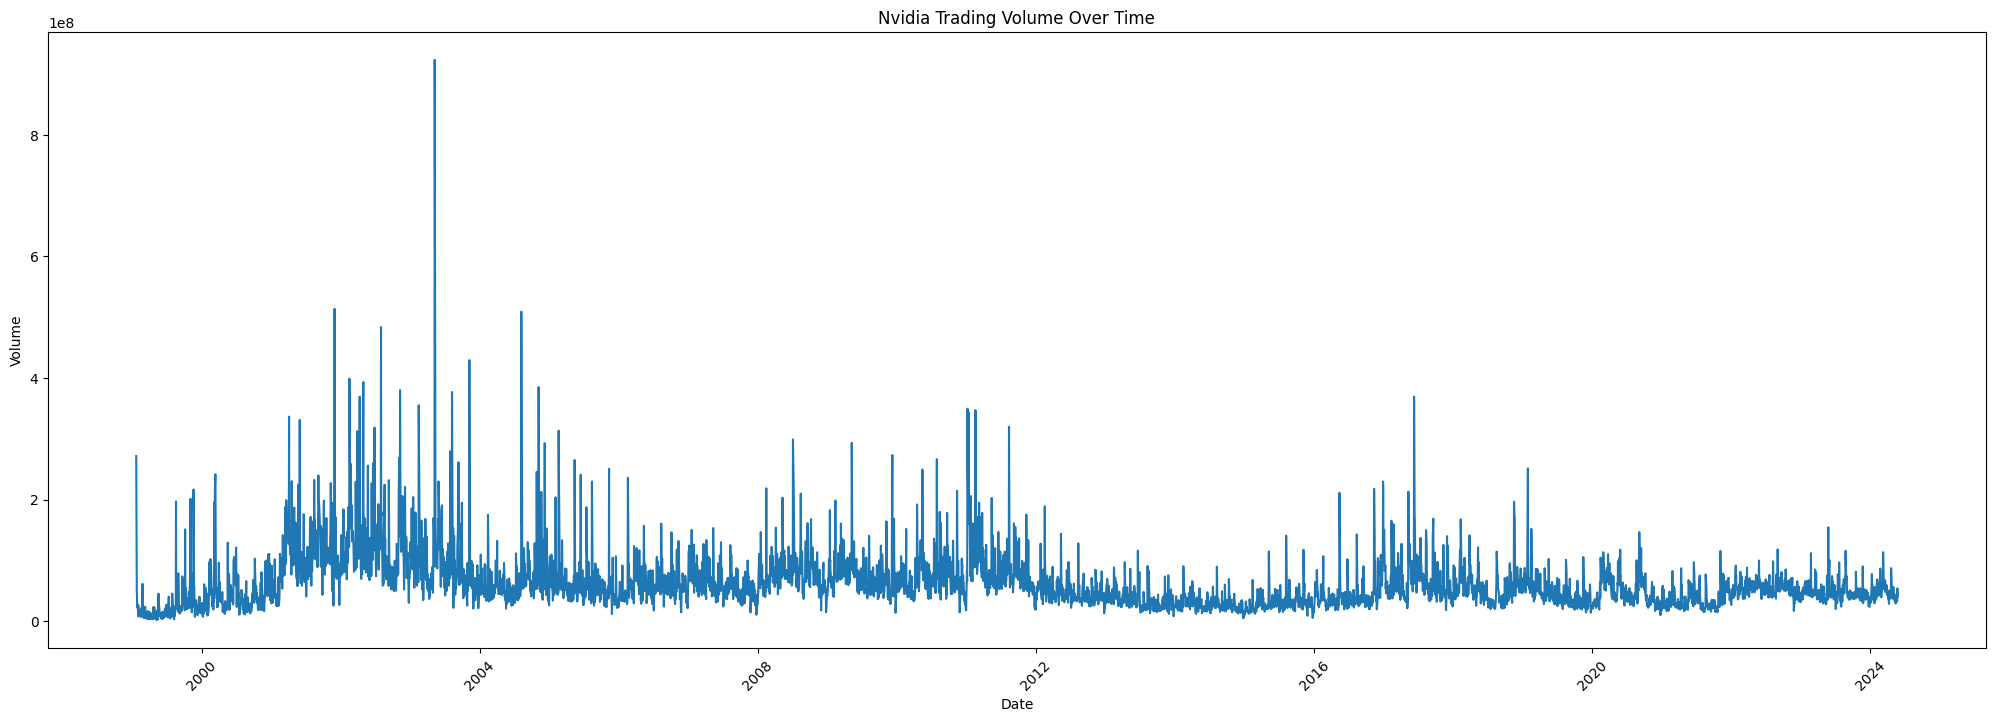

In [2]:
# convert the "Date" column to datetime format
nvidia_df["Date"] = pd.to_datetime(nvidia_df["Date"])

plt.figure(figsize = (25, 8))
plt.plot(nvidia_df["Date"], nvidia_df["Volume"])
plt.title("Nvidia Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")

# get the current axes
ax = plt.gca() 
# set the major locator to YearLocator with base 4
ax.xaxis.set_major_locator(mdates.YearLocator(base = 4))
# set the major formatter to DateFormatter with format '%Y'
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation = 45)
plt.show()

The graphic above represents the trading volume of Nvidia's stock over time.  

The x-axis represents the date, and the y-axis represents the trading volume. The line plot visualizes how the trading volume has changed over time. Each point on the line corresponds to the trading volume on a specific date.  

The trading volume is a measure of how much of a given financial asset has been traded in a specific period. It is a significant indicator as it reflects the level of interest and activity related to the stock.  

This visualization can help us understand the trends and patterns in the trading activity of Nvidia's stock. For instance, periods of high trading volume could indicate important events or announcements related to the company.

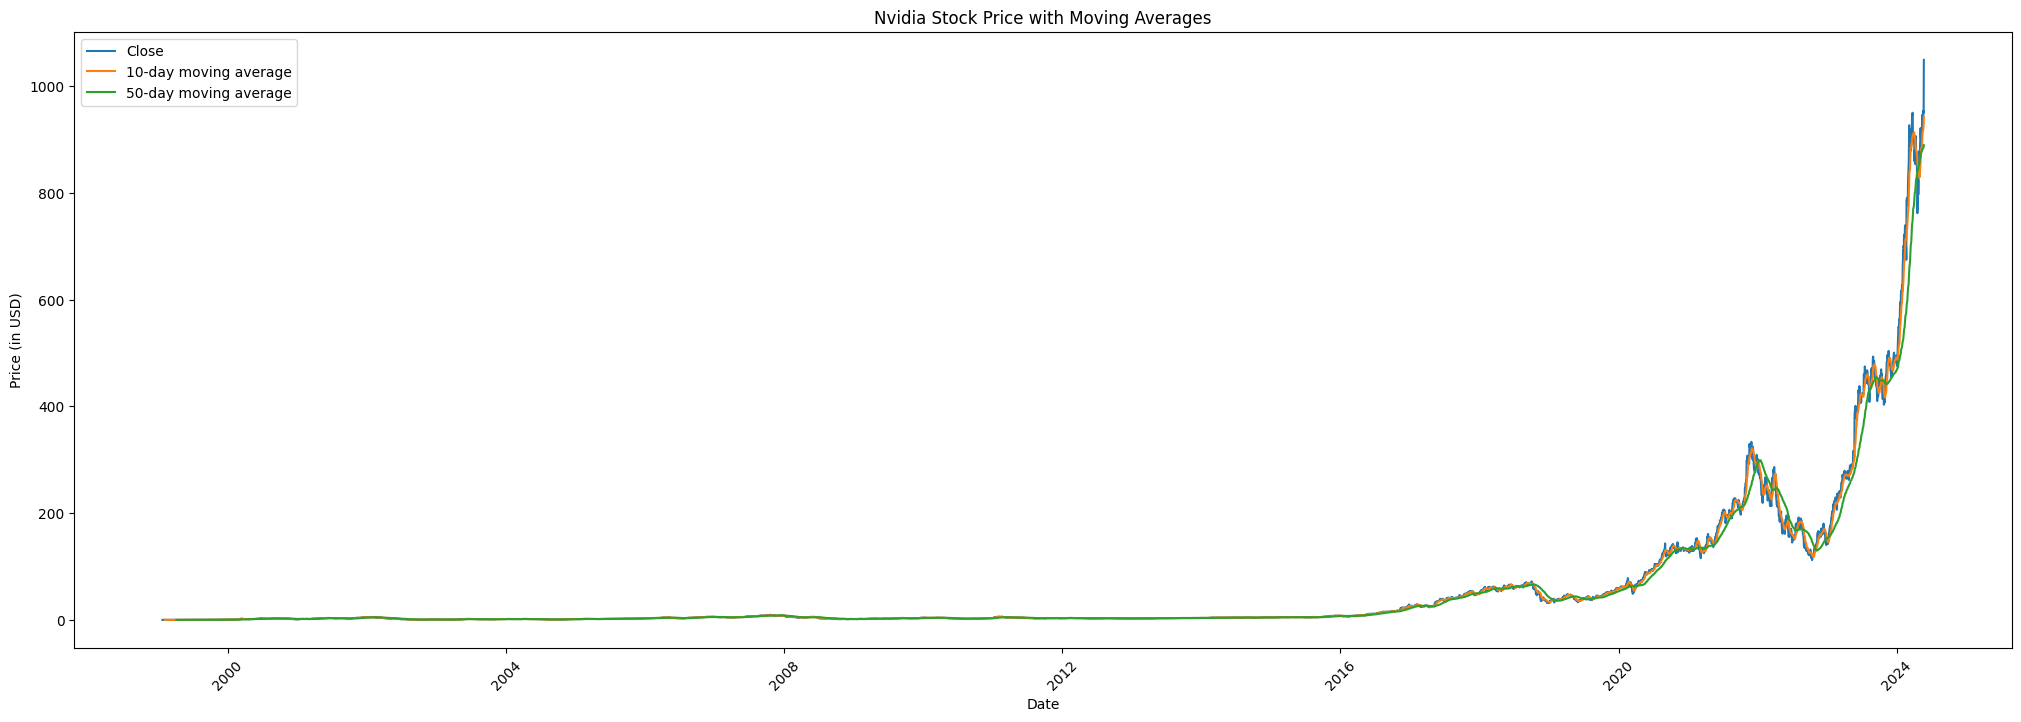

In [3]:
# 10-day moving average
nvidia_df["MA10"] = nvidia_df["Close"].rolling(window = 10).mean()
# 50-day moving average
nvidia_df["MA50"] = nvidia_df["Close"].rolling(window = 50).mean()

plt.figure(figsize = (25, 8))
plt.plot(nvidia_df["Date"], nvidia_df["Close"], label = "Close")
plt.plot(nvidia_df["Date"], nvidia_df["MA10"], label = "10-day moving average")
plt.plot(nvidia_df["Date"], nvidia_df["MA50"], label = "50-day moving average")
plt.title("Nvidia Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (in USD)")
plt.legend(loc = "best")

# format x-ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base = 4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation = 45)
plt.show()

The graphic above represents the closing prices of Nvidia's stock along with the 10-day and 50-day moving averages.

The x-axis represents the date, and the y-axis represents the price in USD. The closing prices are represented by a line labeled "Close". The 10-day moving average is represented by a line labeled "10-day moving average", and the 50-day moving average is represented by a line labeled "50-day moving average".

The 10-day moving average is a commonly used indicator in stock trading, which averages out the closing prices of the last 10 days to smooth out short-term price fluctuations and highlight longer-term trends or patterns.

The 50-day moving average is another commonly used indicator in stock trading, which averages out the closing prices of the last 50 days. It is used to analyze the medium-term trends of a stock's price movement.

This graph provides a visual comparison between the actual closing prices and the moving averages. It can help us understand how the price of Nvidia's stock has changed over time and how these changes align with the moving averages.

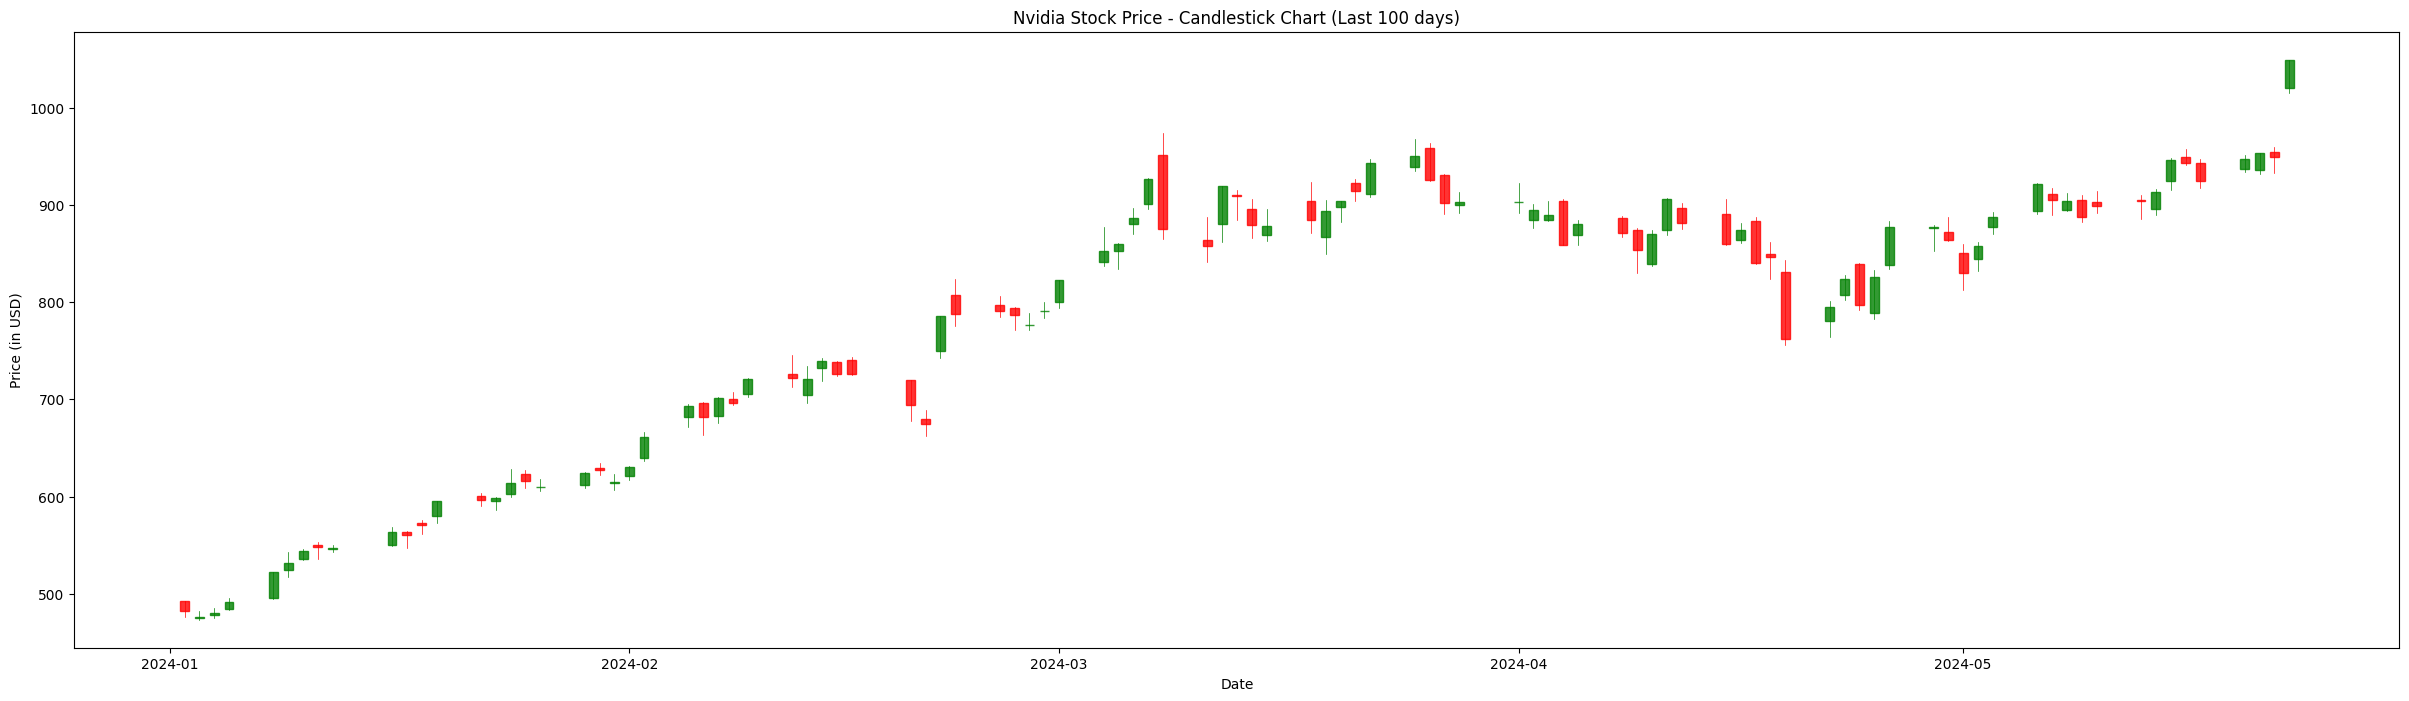

In [4]:
# plot the candlestick chart for the last 100 days
# get the last 100 rows of the dataframe
nvidia_df_last_100 = nvidia_df[-100:].copy()
# convert the "Date" column to matplotlib date format
nvidia_df_last_100["Date"] = nvidia_df_last_100["Date"].map(mdates.date2num)
# get the values of the "Date", "Open", "High", "Low", and "Close" columns
ohlc = nvidia_df_last_100[["Date", "Open", "High", "Low", "Close"]].values

fig, ax = plt.subplots(figsize = (30, 8))
# plot the candlestick chart
candlestick_ohlc(ax, ohlc, width = 0.6, colorup = "green", colordown = "red", alpha = 0.8)
# set the x-axis to display dates
ax.xaxis_date()
plt.title("Nvidia Stock Price - Candlestick Chart (Last 100 days)")
plt.xlabel("Date")
plt.ylabel("Price (in USD)")
plt.show()

The graphic above is a candlestick chart representing the last 100 days of Nvidia's stock price.

In a candlestick chart, each "candlestick" represents one day of trading. The rectangular part, known as the "body", shows the opening and closing prices for the day. If the body is green, it means the closing price was higher than the opening price (a bullish day). If the body is red, it means the closing price was lower than the opening price (a bearish day).

The thin lines sticking out from the body, known as the "wicks" or "shadows", represent the highest and lowest trading prices for the day.

In this specific chart, it shows the stock price movement of Nvidia for the last 100 days.

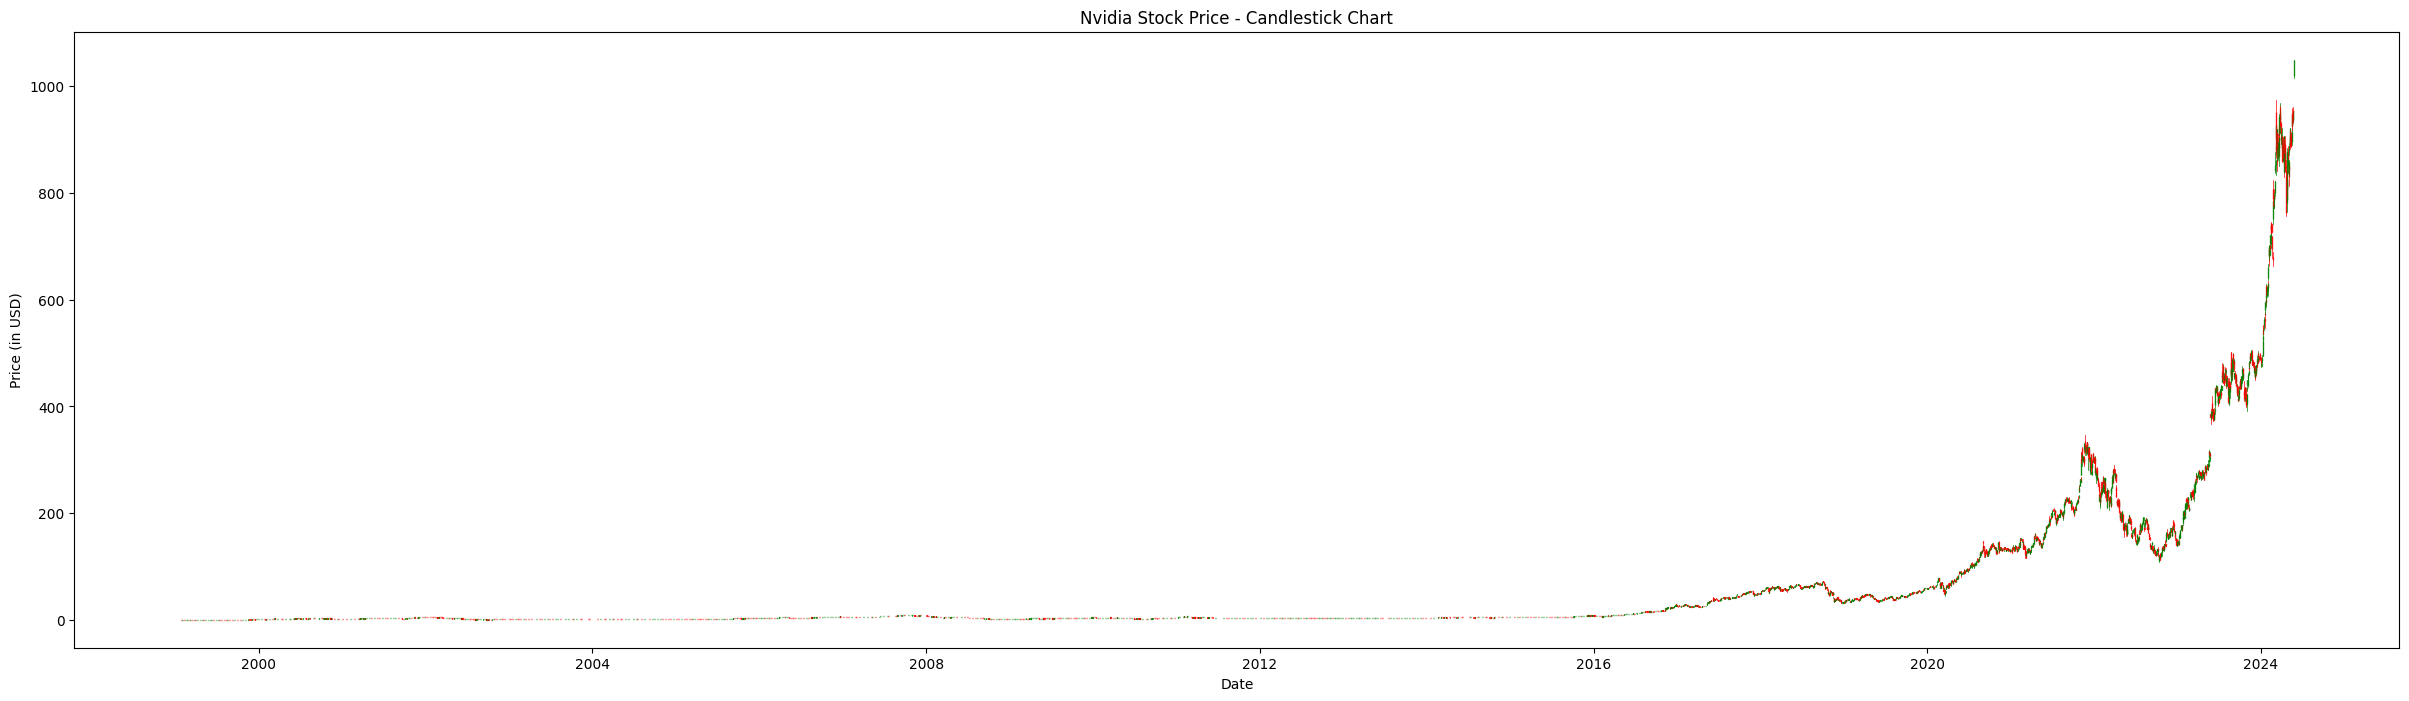

In [5]:
nvidia_df["Date"] = pd.to_datetime(nvidia_df["Date"])
nvidia_df["Date"] = nvidia_df["Date"].apply(mdates.date2num)
ohlc = nvidia_df[["Date", "Open", "High", "Low", "Close"]].values
fig, ax = plt.subplots(figsize = (30, 8))
candlestick_ohlc(ax, ohlc, width = 0.6, colorup = "green", colordown = "red", alpha = 0.8)
ax.xaxis_date()
plt.title("Nvidia Stock Price - Candlestick Chart")
plt.xlabel("Date")
plt.ylabel("Price (in USD)")
plt.show()

###### Predicting Stock Prices with Linear Regression Model (and Moving Averages)

In [6]:
# add a new column "Price_Up" to the dataframe
nvidia_df["Price_Up"] = np.where(nvidia_df["Close"].shift(-1) > nvidia_df["Close"], 1, 0)
# shift the "Price_Up" column by 1 row
nvidia_df["Price_Up"] = nvidia_df["Price_Up"].shift(-1)
nvidia_df = nvidia_df.dropna()
X = nvidia_df[["Date", "Close", "Volume", "MA10", "MA50"]]
y = nvidia_df["Close"]

# split dataset into 80% training, 15% validation, and 5% testing
train_split = int(0.8 * len(X))
val_split = int(0.95 * len(X))
X_train = X[:train_split]
X_val = X[train_split:val_split]
X_test = X[val_split:]
y_train = y[:train_split]
y_val = y[train_split:val_split]
y_test = y[val_split:]

# train a linear regression model
lr = LinearRegression()
lr.fit(X_train.drop("Date", axis = 1), y_train)

# make predictions on the validation set
y_val_pred = lr.predict(X_val.drop("Date", axis = 1))
y_val_pred = pd.Series(y_val_pred, index = y_val.index)
# calculate the mean squared error on the validation set
mse_val = mean_squared_error(y_val, y_val_pred)
print("Validation Mean Squared Error: {}".format(mse_val))

# make predictions on the test set
y_test_pred = lr.predict(X_test.drop("Date", axis = 1))
y_test_pred = pd.Series(y_test_pred, index = y_test.index)
# calculate the mean squared error on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
print("Test Mean Squared Error: {}".format(mse_test))

Validation Mean Squared Error: 1.4246769330057555e-21
Test Mean Squared Error: 1.0434972386578596e-21


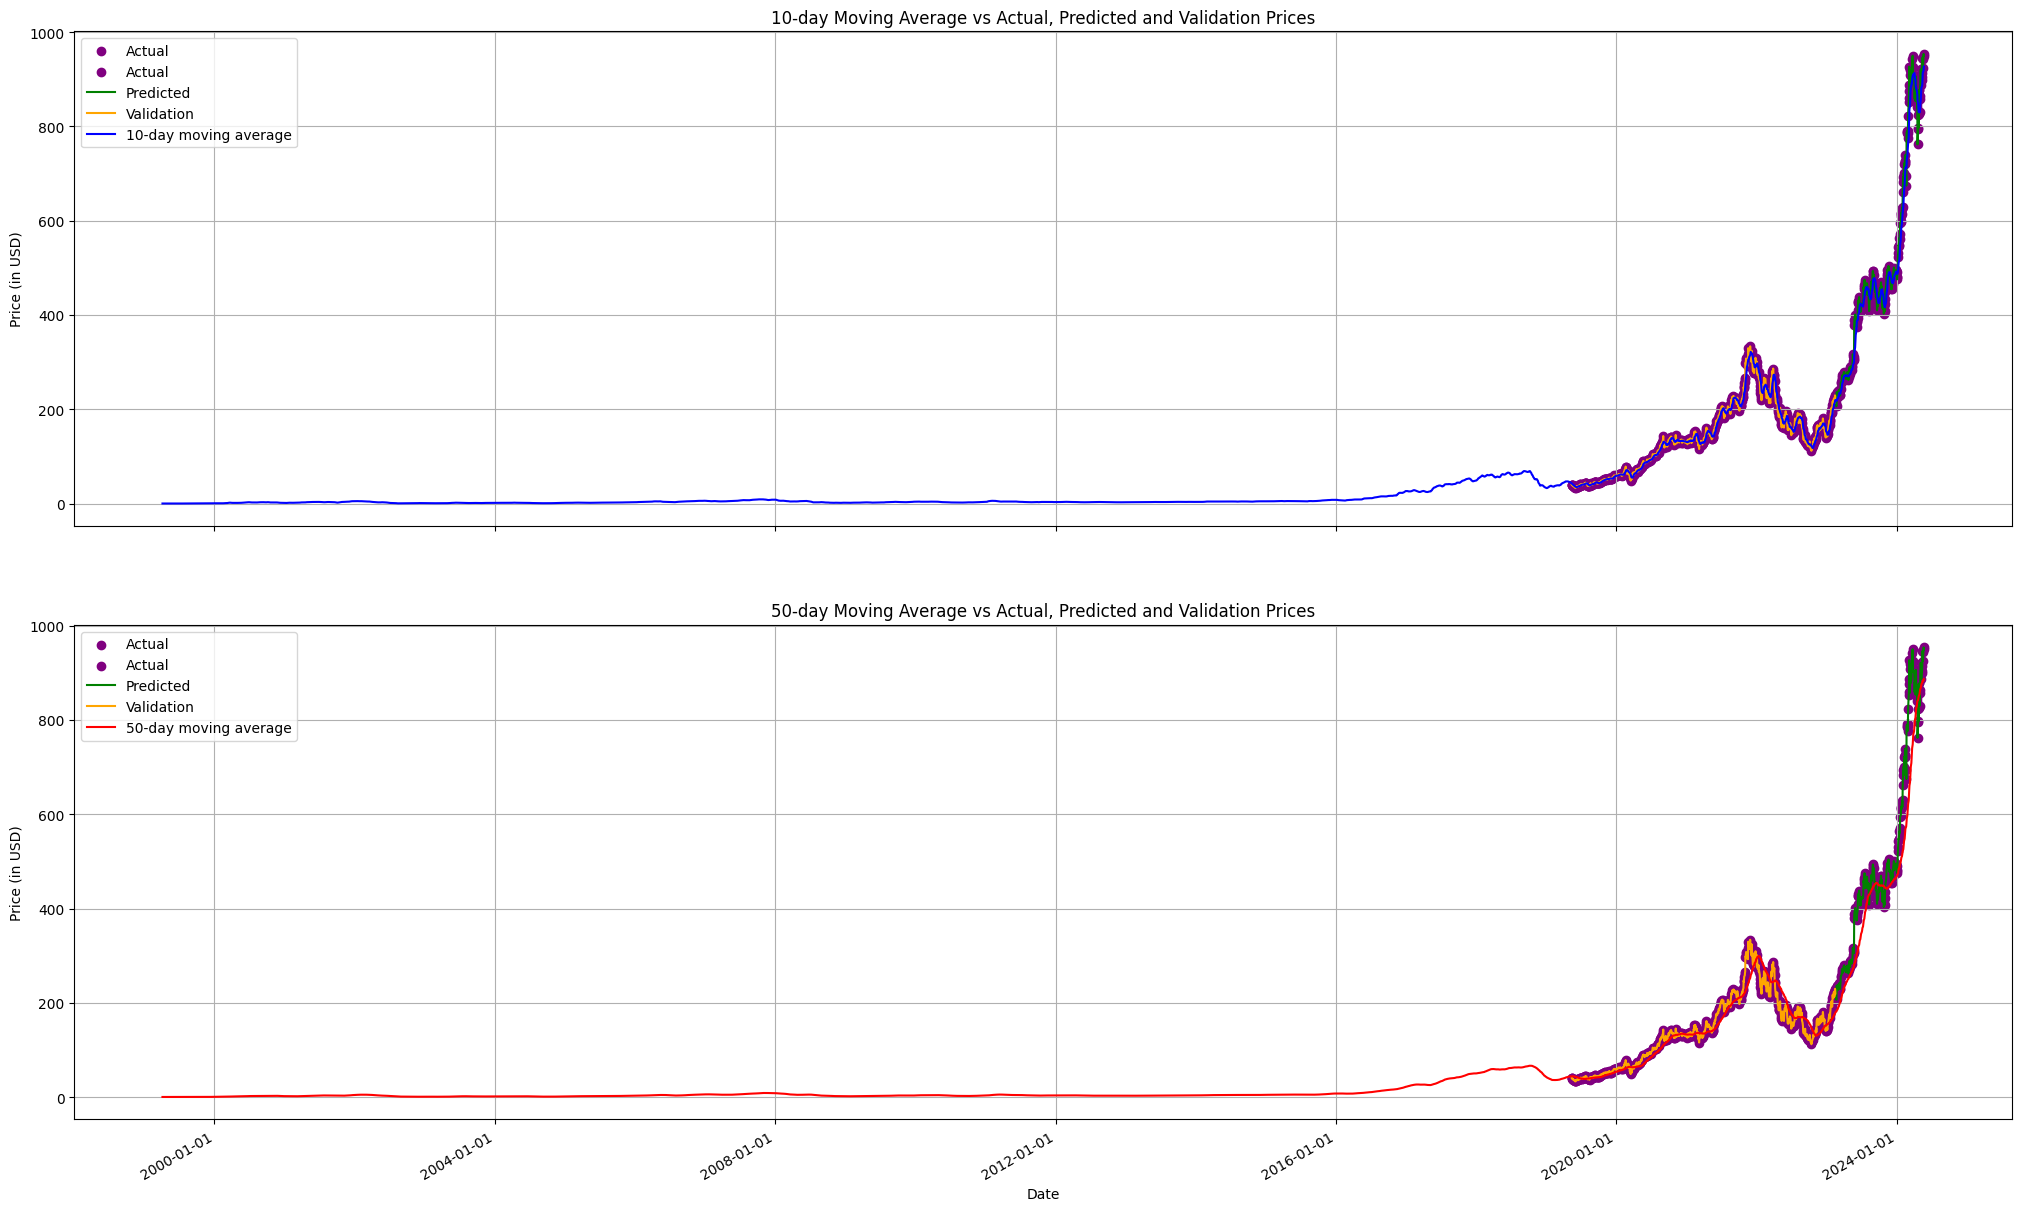

In [7]:
# plot the actual, predicted, and validation prices along with the moving averages
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (25, 16), sharex = True)

# plot for the 10-day moving average
ax1.scatter(X_test["Date"], y_test.values, label = "Actual", color = "purple")
ax1.scatter(X_val["Date"], y_val.values, label = "Actual", color = "purple")
ax1.plot(X_test["Date"], y_test_pred.values, label = "Predicted", color = "green")
ax1.plot(X_val["Date"], y_val_pred.values, label = "Validation", color = "orange")
ax1.plot(nvidia_df["Date"], nvidia_df["MA10"], label="10-day moving average", color = "blue")
ax1.set_title("10-day Moving Average vs Actual, Predicted and Validation Prices")
ax1.set_ylabel("Price (in USD)")
ax1.legend(loc = "best")
ax1.grid(True)

# plot for the 50-day moving average
ax2.scatter(X_test["Date"], y_test.values, label = "Actual", color = "purple")
ax2.scatter(X_val["Date"], y_val.values, label = "Actual", color = "purple")
ax2.plot(X_test["Date"], y_test_pred.values, label = "Predicted", color = "green")
ax2.plot(X_val["Date"], y_val_pred.values, label = "Validation", color = "orange")
ax2.plot(nvidia_df["Date"], nvidia_df["MA50"], label = "50-day moving average", color = "red")
ax2.set_title("50-day Moving Average vs Actual, Predicted and Validation Prices")
ax2.set_xlabel("Date")
ax2.set_ylabel("Price (in USD)")
ax2.legend(loc="best")
ax2.grid(True)

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.YearLocator(base=4))
ax2.xaxis.set_major_locator(mdates.YearLocator(base=4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

The two graphs above represent the actual, predicted, and validation prices of Nvidia's stock along with the 10-day and 50-day moving averages.  

The first graph shows the 10-day moving average, actual, predicted, and validation prices. The actual prices are represented by purple dots, the predicted prices by a green line, and the validation prices by an orange line. The 10-day moving average is represented by a blue line. The 10-day moving average is a commonly used indicator in stock trading, which averages out the closing prices of the last 10 days to smooth out short-term price fluctuations and highlight longer-term trends or patterns.  

The second graph shows the 50-day moving average, actual, predicted, and validation prices. The actual prices are represented by purple dots, the predicted prices by a green line, and the validation prices by an orange line. The 50-day moving average is represented by a red line. The 50-day moving average is another commonly used indicator in stock trading, which averages out the closing prices of the last 50 days. It is used to analyze the medium-term trends of a stock's price movement.  

In both graphs, the x-axis represents the date, and the y-axis represents the price in USD. The legends in the graphs indicate which color corresponds to which data series. The grid lines in the graphs help to better visualize and compare the values.  

These graphs provide a visual comparison between the actual, predicted, and validation prices, and the moving averages. They can help us understand how well the model is predicting the stock prices and how these predictions align with the actual prices and moving averages. Based on the visualization, we can see that the predicted prices are following a similar trend to the actual prices and moving averages, indicating that the linear regression model is capturing some of the patterns in the data. However, we could investigate the linear regression with using 10 Day Moving average was performing better than 50 Day Moving average, as the 10 Day Moving average was more closely aligned with the actual prices.

###### Using deep learning to predict stock prices (only using the closing prices) and using LSTM model. The used data is from 2020 to the latest date.

In [8]:
# define a custom LSTM model for predicting stock prices
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super(StockPriceLSTM, self).__init__()
        # define the LSTM layer with input size, hidden layer size, number of layers, and batch_first set to True
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True).to(device)
        self.linear = nn.Linear(hidden_layer_size, output_size).to(device)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        hidden_cell = self.init_hidden(batch_size)
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1).to(device))
        lstm_out = lstm_out[:,-1,:]
        predictions = self.linear(lstm_out)
        return predictions.flatten()

    def init_hidden(self, batch_size):
        # initialize hidden and cell states
        return (torch.zeros(self.lstm.num_layers, batch_size, self.hidden_layer_size).to(device),
                torch.zeros(self.lstm.num_layers, batch_size, self.hidden_layer_size).to(device))

In [9]:
# define a function called train_epoch that takes in the model, train_loader, criterion, and optimizer as input
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        output = output.view(-1)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [10]:
# define a function called flat_accuracy that takes in the predictions and labels as input
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [11]:
# define a function called eval_model that takes in the model, test_loader, and criterion as input
def eval_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    for inputs, targets in test_loader:
        output = model(inputs)
        output = output.view(-1)
        loss = criterion(output, targets)
        total_loss += loss.item()
    return total_loss / len(test_loader)

In [12]:
# load the nvidia stock price dataset again and preprocess it
nvidia_df = pd.read_csv('nvidia_stock_price.csv')
# convert the "Date" column to datetime format
nvidia_df["Date"] = pd.to_datetime(nvidia_df["Date"])
# filter the data to include only dates from 2020 to the latest date in the dataset (due to earlier data being less relevant for prediction purposes)
nvidia_df = nvidia_df[nvidia_df["Date"] >= "2020-01-01"]
nvidia_df = nvidia_df.sort_values("Date")

# split the dataset into training, validation, and test sets (80%, 15%, 5%)
train_split = int(0.8 * len(nvidia_df))
val_split = int(0.95 * len(nvidia_df))
X_train = nvidia_df[["Close"]][:train_split]
X_val = nvidia_df[["Close"]][train_split:val_split]
X_test = nvidia_df[["Close"]][val_split:]
y_train = nvidia_df["Close"][:train_split]
y_val = nvidia_df["Close"][train_split:val_split]
y_test = nvidia_df["Close"][val_split:]

# using the min-max scaling to scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler.transform(y_val.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

In [13]:
# create a custom dataset class called StockDataset
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        # convert the features and labels to PyTorch tensors and move them to the device
        self.features = torch.tensor(features).float().to(device)
        self.labels = torch.tensor(labels).float().to(device).view(-1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # return the features and labels at the given index
        return self.features[idx], self.labels[idx]

In [14]:
# define the objective function for the Optuna study to minimize the validation loss using the LSTM model with hyperparameters as input parameters
def objective(trial):
    # suggest a value for the hidden layer size between 1 and 100
    hidden_layer_size = trial.suggest_int("hidden_layer_size", 1, 100)
    # suggest a value for the learning rate between 1e-5 and 1e-1
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1)
    # suggest a value for the batch size between 1 and 32
    batch_size = trial.suggest_int("batch_size", 1, 32)
    # suggest a value for the number of epochs between 50 and 1000
    num_epochs = trial.suggest_int("num_epochs", 50, 1000)
    # suggest a value for the number of layers between 1 and 3
    num_layers = trial.suggest_int("num_layers", 1, 3)

    # initialize the LSTM model with the suggested parameters
    model = StockPriceLSTM(1, hidden_layer_size, 1, num_layers).to(device)
    # define the loss function as mse
    criterion = nn.MSELoss()
    # define the optimizer as AdamW with the suggested learning rate
    optimizer = AdamW(model.parameters(), lr = learning_rate)
    # define the learning rate scheduler as StepLR with step size 1 and gamma 0.7
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.7)

    # create datasets using StockDataset and DataLoader
    train_dataset = StockDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
    val_dataset = StockDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

    # train the model for the suggested number of epochs
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        scheduler.step()
    # evaluate the model on the validation set
    val_loss = eval_model(model, val_loader, criterion)
    return val_loss

# create an Optuna study that aims to minimize the objective function with 5 trials and optimize the hyperparameters for the LSTM model using the validation loss as the metric to minimize
study = optuna.create_study(direction = "minimize")
# can edit the n_trials to increase the number of trials for better optimization by your choice
study.optimize(objective, n_trials = 5)

# print the number of finished trials and the best trial with its value and parameters for the LSTM model hyperparameters
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-11 00:18:06,541] A new study created in memory with name: no-name-cd217382-5c5c-4c9c-9fe7-b13816b88a3a
[I 2024-06-11 00:18:25,287] Trial 0 finished with value: 0.004353434816169154 and parameters: {'hidden_layer_size': 56, 'learning_rate': 0.037387397738337665, 'batch_size': 24, 'num_epochs': 754, 'num_layers': 1}. Best is trial 0 with value: 0.004353434816169154.
[I 2024-06-11 00:18:31,931] Trial 1 finished with value: 0.9791464110215505 and parameters: {'hidden_layer_size': 21, 'learning_rate': 0.035910062934386075, 'batch_size': 32, 'num_epochs': 293, 'num_layers': 3}. Best is trial 0 with value: 0.004353434816169154.
[I 2024-06-11 00:22:03,618] Trial 2 finished with value: 0.13126667722756694 and parameters: {'hidden_layer_size': 85, 'learning_rate': 0.04418916195484875, 'batch_size': 1, 'num_epochs': 238, 'num_layers': 2}. Best is trial 0 with value: 0.004353434816169154.
[I 2024-06-11 00:26:13,140] Trial 3 finished with value: 0.1526453331595354 and parameters: {'hidde

Number of finished trials:  5
Best trial:
  Value:  0.004353434816169154
  Params: 
    hidden_layer_size: 56
    learning_rate: 0.037387397738337665
    batch_size: 24
    num_epochs: 754
    num_layers: 1


In [15]:
# get the best hyperparameters from the Optuna study and train the LSTM model with the best hyperparameters on the training set
hidden_layer_size = trial.params["hidden_layer_size"]
learning_rate = trial.params["learning_rate"]
batch_size = trial.params["batch_size"]
num_epochs = trial.params["num_epochs"]
num_layer = trial.params["num_layers"]

# initialize the LSTM model with the best hyperparameters and train it on the training set
model = StockPriceLSTM(1, hidden_layer_size, 1, num_layer).to(device)
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.7)

train_dataset = StockDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
val_dataset = StockDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    scheduler.step()
val_loss = eval_model(model, val_loader, criterion)
print("Validation Loss: ", val_loss)

model.eval()
val_predictions = []
val_actuals = []
for inputs, targets in val_loader:
    output = model(inputs)
    val_predictions.extend(output.cpu().detach().numpy())
    val_actuals.extend(targets.cpu().detach().numpy())

# prepare the test dataset and loader
test_dataset = StockDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

# evaluate the model on the test set
test_loss = eval_model(model, test_loader, criterion)
print("Test Loss: ", test_loss)

# make predictions on the test set
model.eval()
predictions = []
actuals = []
for inputs, targets in test_loader:
    output = model(inputs)
    predictions.extend(output.cpu().detach().numpy())
    actuals.extend(targets.cpu().detach().numpy())
    
# calculate the Mean Squared Error on the test set predictions and actuals
mse = mean_squared_error(actuals, predictions)
print("Mean Squared Error: ", mse)

Validation Loss:  0.029586094498102154
Test Loss:  0.48052387436230976
Mean Squared Error:  0.44198126


In [16]:
# inverse transform the scaled predictions and actuals to get the actual stock prices in USD using the MinMaxScaler object used for scaling the data earlier
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
val_predictions = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1))
val_actuals = scaler.inverse_transform(np.array(val_actuals).reshape(-1, 1))
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

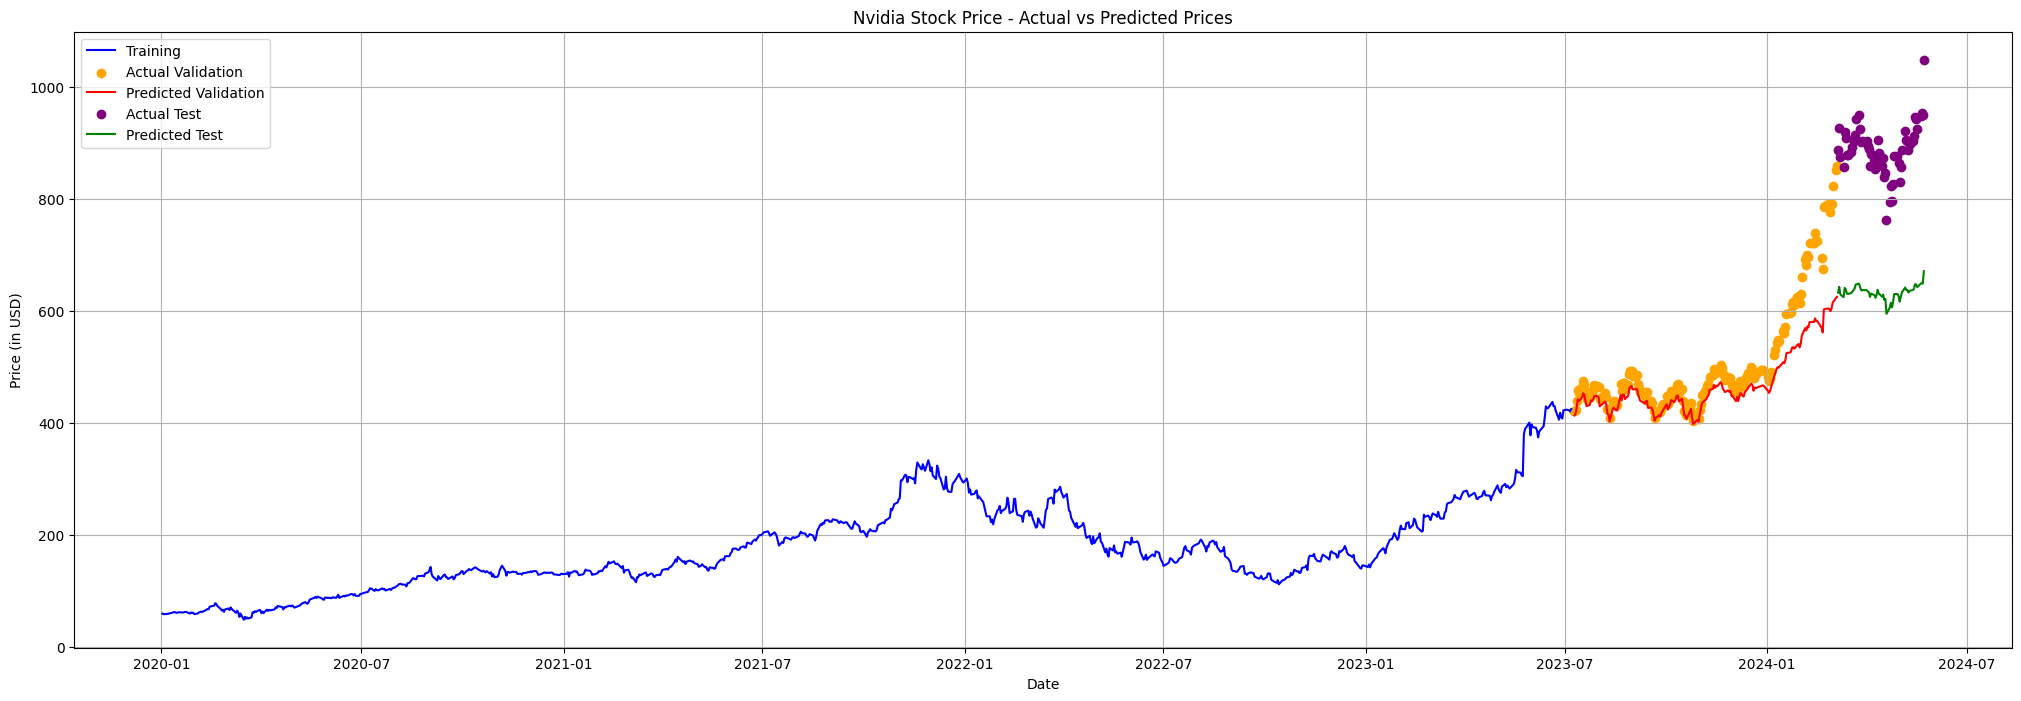

In [20]:
# assuming dates_train and dates_val are lists or arrays that contain the dates for the training and validation sets
dates_train = nvidia_df["Date"][:train_split]
dates_val = nvidia_df["Date"][train_split:val_split]
dates_test = nvidia_df["Date"][val_split:]

# plot the training, validation, and test data along with the predictions
fig, ax = plt.subplots(figsize = (25, 8))
ax.plot(dates_train, y_train, label = "Training", color = "blue")
ax.scatter(dates_val, val_actuals, label = "Actual Validation", color = "orange")
ax.plot(dates_val, val_predictions, label = "Predicted Validation", color = "red")
ax.scatter(dates_test, y_test, label = "Actual Test", color = "purple")
ax.plot(dates_test, predictions, label = "Predicted Test", color = "green")
ax.set_title("Nvidia Stock Price - Actual vs Predicted Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price (in USD)")
ax.legend(loc = "best")
ax.grid(True)
plt.show()

The graph above represents the actual and predicted stock prices of Nvidia along with the training, validation, and test data by using the LSTM model with the best hyperparameters and get the Mean Squared Error on the test set predictions and actuals as 0.44198126. There are having some differences between the actual and predicted prices, but the model is capturing the general trends and patterns in the data. The training data is represented by the blue line, the actual validation prices by orange dots, the predicted validation prices by a red line, the actual test prices by purple dots, and the predicted test prices by a green line. The x-axis represents the date, and the y-axis represents the price in USD. The legend in the graph indicates which color corresponds to which data series. The grid lines in the graph help to better visualize and compare the values.

This graph provides a visual comparison between the actual and predicted stock prices of Nvidia using the LSTM model. It can help us understand how well the model is predicting the stock prices and how these predictions align with the actual prices. Based on the visualization, we can see that the predicted prices are following a similar trend to the actual prices, indicating that the LSTM model is capturing some of the patterns in the data.

For the future enhancements, we could try different hyperparameters, such as the number of hidden layers, learning rate, and batch size, to see if we can improve the model's performance. We could also experiment with different architectures, such as using a bidirectional LSTM or adding dropout layers to prevent overfitting. Additionally, we could explore other features or technical indicators that could potentially improve the model's predictive power.